In [1]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump, load
import os
import json

In [2]:
# Chargement des données
df = pd.read_csv('data/it_jobs_data.csv')

In [3]:
# Affichage des premières lignes et informations sur le dataset
print(df.head())
print(df.info())

   work_year experience_level employment_type               job_title  salary  \
0       2024      Entry-level       Freelance  Applied Data Scientist   30000   
1       2024        Executive       Full-time   Business Intelligence  230000   
2       2024        Executive       Full-time   Business Intelligence  176900   
3       2024           Senior       Full-time          Data Architect  171210   
4       2024           Senior       Full-time          Data Architect   92190   

  salary_currency  salary_in_usd employee_residence work_setting  \
0             USD          30000     United Kingdom       Remote   
1             USD         230000      United States    In-person   
2             USD         176900      United States    In-person   
3             USD         171210             Canada    In-person   
4             USD          92190             Canada    In-person   

  company_location company_size                    job_category  
0   United Kingdom            M       

In [4]:
# Analyse exploratoire des données
print(df.describe())
print(df['job_category'].value_counts())
print(df['experience_level'].value_counts())

          work_year         salary  salary_in_usd
count  14199.000000   14199.000000    14199.00000
mean    2023.110501  149057.514262   149472.04944
std        0.686929   64932.044143    64379.26016
min     2020.000000   14000.000000    15000.00000
25%     2023.000000  102150.000000   104000.00000
50%     2023.000000  142000.000000   142000.00000
75%     2024.000000  185900.000000   185900.00000
max     2024.000000  450000.000000   450000.00000
job_category
Data Science and Research         4675
Data Engineering                  3157
Data Analysis                     2204
Machine Learning and AI           2148
Leadership and Management          791
BI and Visualization               600
Data Architecture and Modeling     419
Data Management and Strategy       115
Data Quality and Operations         79
Cloud and Database                  11
Name: count, dtype: int64
experience_level
Senior         9381
Mid-level      3339
Entry-level    1063
Executive       416
Name: count, dtype: int6

In [5]:
# Préparation des données
X = df[['work_year', 'experience_level', 'employment_type', 'job_title', 'employee_residence', 'work_setting', 'company_location', 'company_size', 'job_category']]
y = df['salary_in_usd']

In [6]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Prétraitement des données
categorical_features = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'work_setting', 'company_location', 'company_size', 'job_category']
numeric_features = ['work_year']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


In [8]:
# Création et entraînement du modèle
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_preprocessed, y_train)


RandomForestRegressor(random_state=42)

In [9]:
# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test_preprocessed)

In [10]:
# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: ${rmse:.2f}")
print(f"R2 Score: {r2:.2f}")


RMSE: $52531.44
R2 Score: 0.34


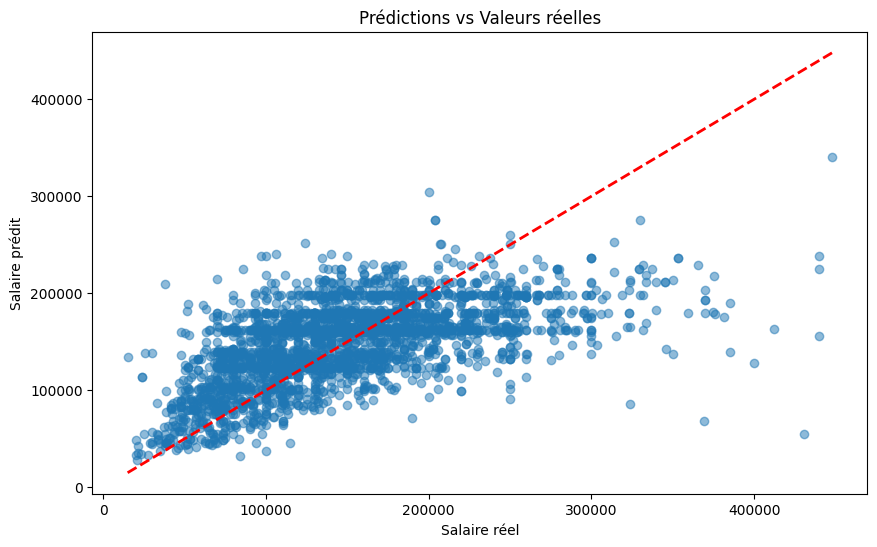

In [11]:
# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Salaire réel")
plt.ylabel("Salaire prédit")
plt.title("Prédictions vs Valeurs réelles")
plt.show()

In [12]:
# Test du modèle avec des exemples spécifiques
new_data = pd.DataFrame({
    'work_year': [2024, 2024],
    'experience_level': ['Senior', 'Entry-level'],
    'employment_type': ['Full-time', 'Full-time'],
    'job_title': ['Data Scientist', 'Software Engineer'],
    'employee_residence': ['United States', 'Canada'],
    'work_setting': ['Remote', 'In-person'],
    'company_location': ['United States', 'Canada'],
    'company_size': ['M', 'L'],
    'job_category': ['Data Science and Research', 'Software Engineering']
})

new_data_preprocessed = preprocessor.transform(new_data)
predictions = model.predict(new_data_preprocessed)

for i, pred in enumerate(predictions):
    print(f"Exemple {i+1}: Salaire prédit = ${pred:.2f}")


Exemple 1: Salaire prédit = $163268.43
Exemple 2: Salaire prédit = $85761.64


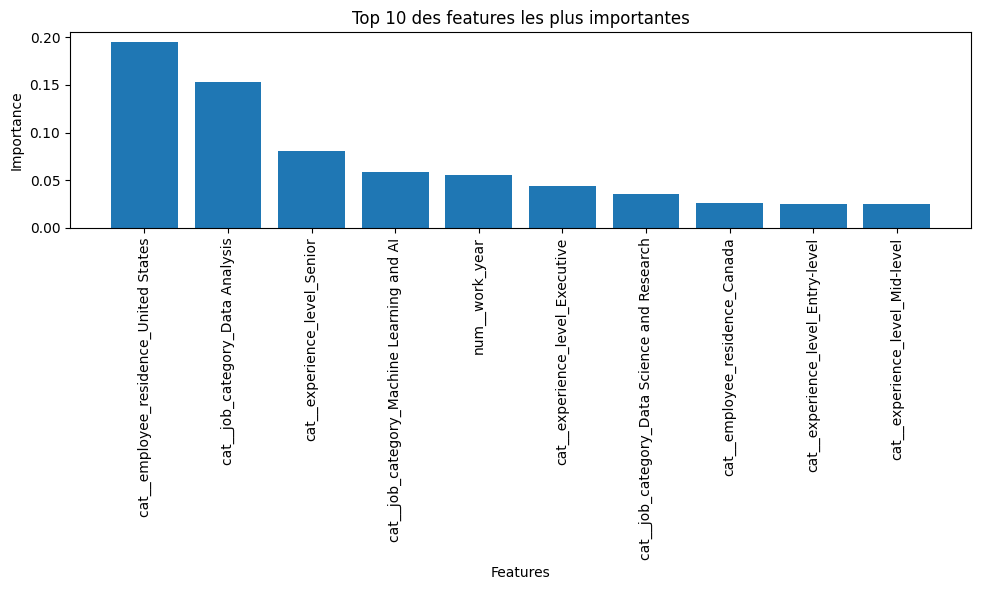

In [13]:
# Analyse de l'importance des features
feature_importance = model.feature_importances_
feature_names = preprocessor.get_feature_names_out()

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['feature'][:10], feature_importance_df['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Top 10 des features les plus importantes")
plt.tight_layout()
plt.show()

In [14]:
# Fonction pour gérer le versionnage du modèle
def get_model_version():
    version_file = 'model/version.json'
    if os.path.exists(version_file):
        with open(version_file, 'r') as f:
            version_info = json.load(f)
        version = version_info['version']
    else:
        version = 0.0
    return version

def update_model_version():
    version_file = 'model/version.json'
    version = get_model_version() + 0.1
    with open(version_file, 'w') as f:
        json.dump({'version': version}, f)
    return version


In [15]:
# Sauvegarde du modèle et du préprocesseur
if not os.path.exists('model'):
    os.makedirs('model')

In [16]:
# Mise à jour de la version du modèle
new_version = update_model_version()

dump(model, f'model/salary_prediction_model_v{new_version:.1f}.joblib')
dump(preprocessor, f'model/preprocessor_v{new_version:.1f}.joblib')

print(f"Le modèle et le préprocesseur version {new_version:.1f} ont été sauvegardés dans le dossier 'model'.")

Le modèle et le préprocesseur version 0.1 ont été sauvegardés dans le dossier 'model'.
